In [35]:
# --- 1. Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Set Seaborn style and Matplotlib parameters
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [36]:
# --- 2. Load Datasets ---
dataset1 = pd.read_csv("covid.csv")
dataset2 = pd.read_csv("covid_grouped.csv")
dataset3 = pd.read_csv("coviddeath.csv")

In [37]:
# --- 3. Data Cleaning ---
dataset1.drop(['NewCases', 'NewDeaths', 'NewRecovered'], axis=1, inplace=True)
df_US = dataset2[dataset2["Country/Region"]=="US"]

In [38]:
# --- 4. Data Cleaning (Safe Version) ---
# Drop unused columns only if they exist
dataset1.drop(columns=['NewCases', 'NewDeaths', 'NewRecovered'], axis=1, inplace=True, errors='ignore')

# Filter dataset2 for the United States
df_US = dataset2[dataset2["Country/Region"] == "US"]


In [39]:
# --- 5. Helper Functions ---
def bar_plot(data, x, y, title, palette='Reds', horizontal=False):
    """
    Draws a bar plot compatible with Seaborn 0.14+ (no warnings).
    """
    plt.figure(figsize=(12,6))
    if horizontal:
        sns.barplot(data=data, y=x, x=y, hue=y, palette=palette, dodge=False, legend=False)
    else:
        sns.barplot(data=data, x=x, y=y, hue=x, palette=palette, dodge=False, legend=False)
        plt.xticks(rotation=45)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def scatter_plot(data, x, y, size_col, hue_col, title, log_scale_x=False, log_scale_y=False):
    """
    Creates scatter plots with color and size encoding.
    """
    plt.figure(figsize=(12,6))
    sns.scatterplot(
        data=data, x=x, y=y, size=size_col, hue=hue_col,
        palette='coolwarm', sizes=(50,500), alpha=0.7, edgecolor='k', legend=False
    )
    if log_scale_x:
        plt.xscale('log')
    if log_scale_y:
        plt.yscale('log')
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def generate_wordcloud(text, title, figsize=(15,15)):
    """
    Generates and displays a word cloud from text.
    """
    plt.figure(figsize=figsize)
    wordcloud = WordCloud(width=1200, height=1200, background_color='white', colormap='coolwarm').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()



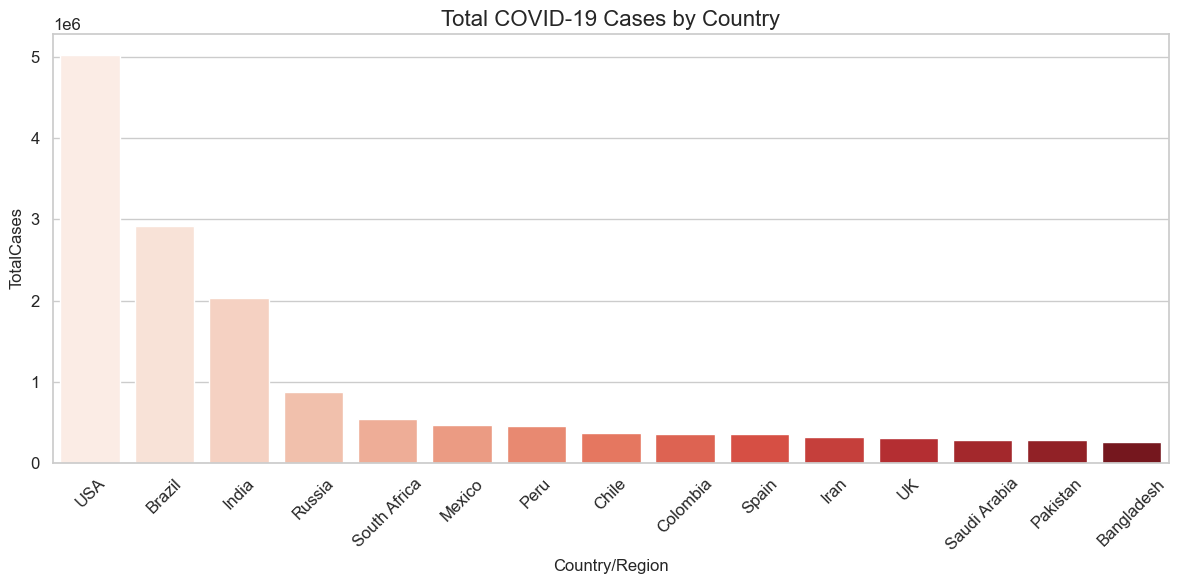

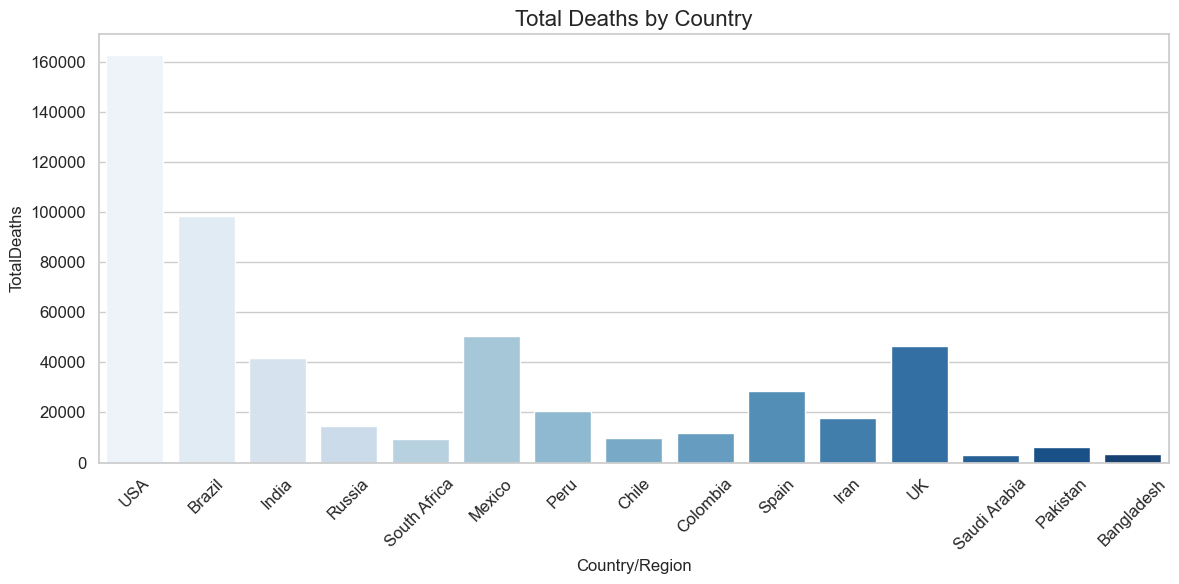

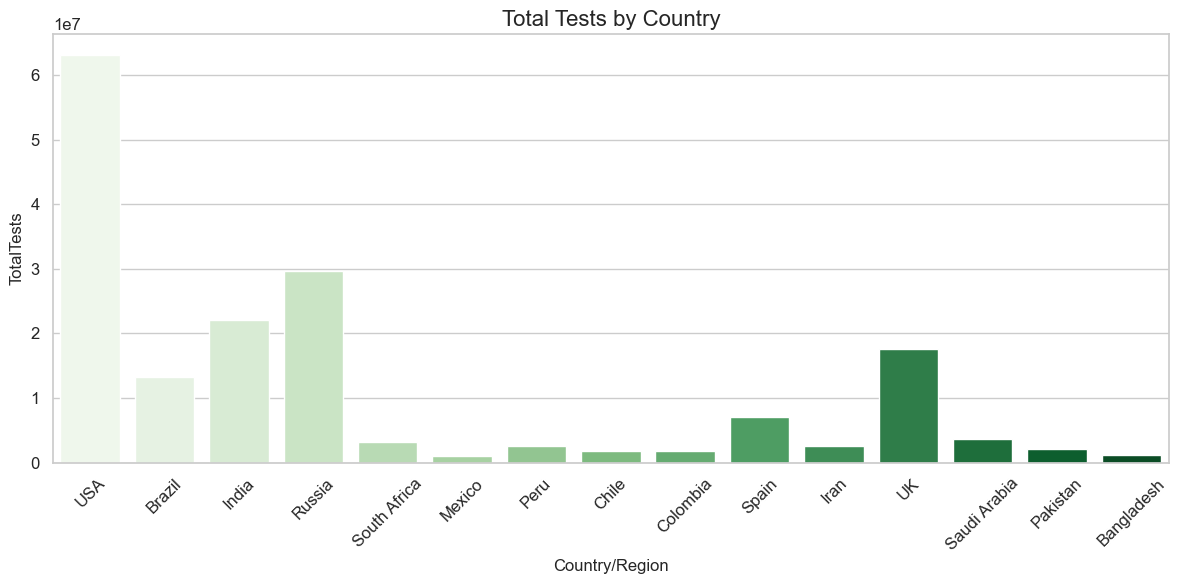

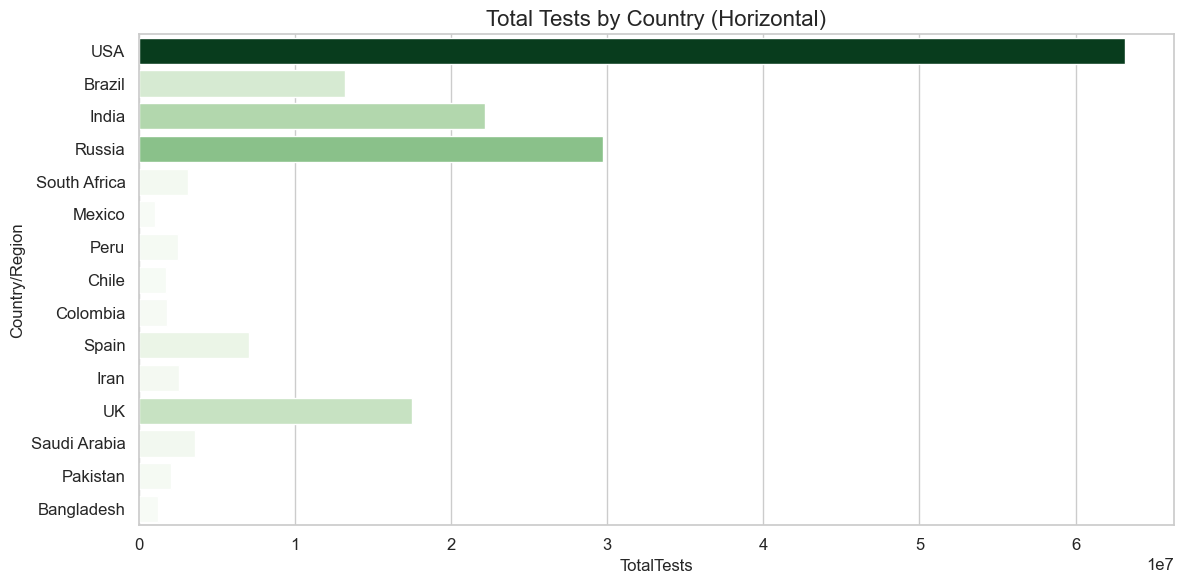

In [40]:
# --- 6. Bar Plots (Top 15 Countries) ---
top15 = dataset1.head(15)

bar_plot(top15, 'Country/Region', 'TotalCases', "Total COVID-19 Cases by Country", palette='Reds')
bar_plot(top15, 'Country/Region', 'TotalDeaths', "Total Deaths by Country", palette='Blues')
bar_plot(top15, 'Country/Region', 'TotalTests', "Total Tests by Country", palette='Greens')
bar_plot(top15, 'Country/Region', 'TotalTests', "Total Tests by Country (Horizontal)", palette='Greens', horizontal=True)



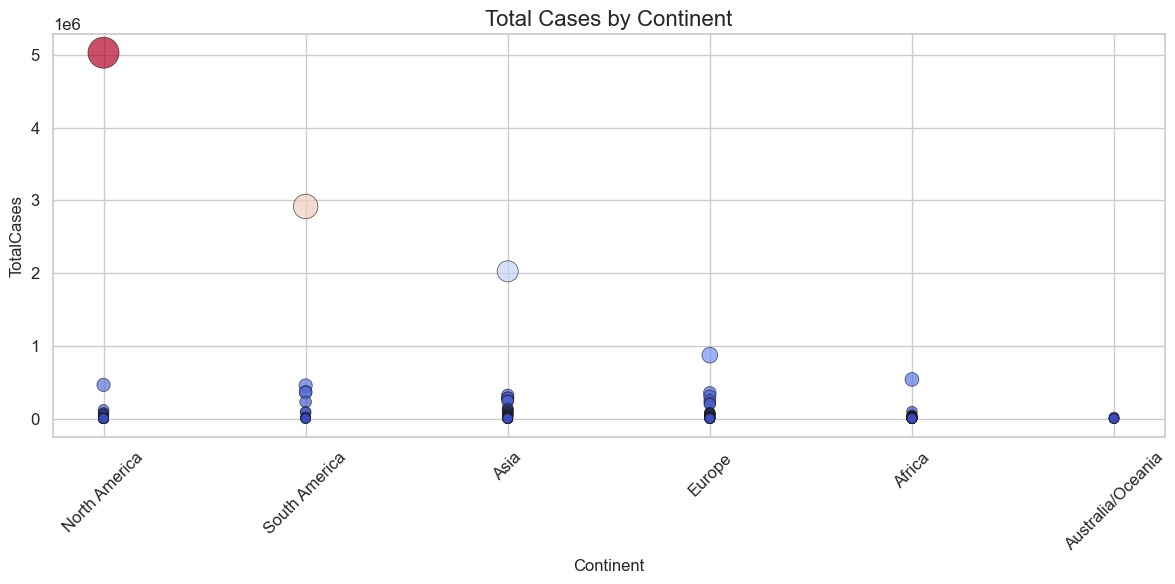

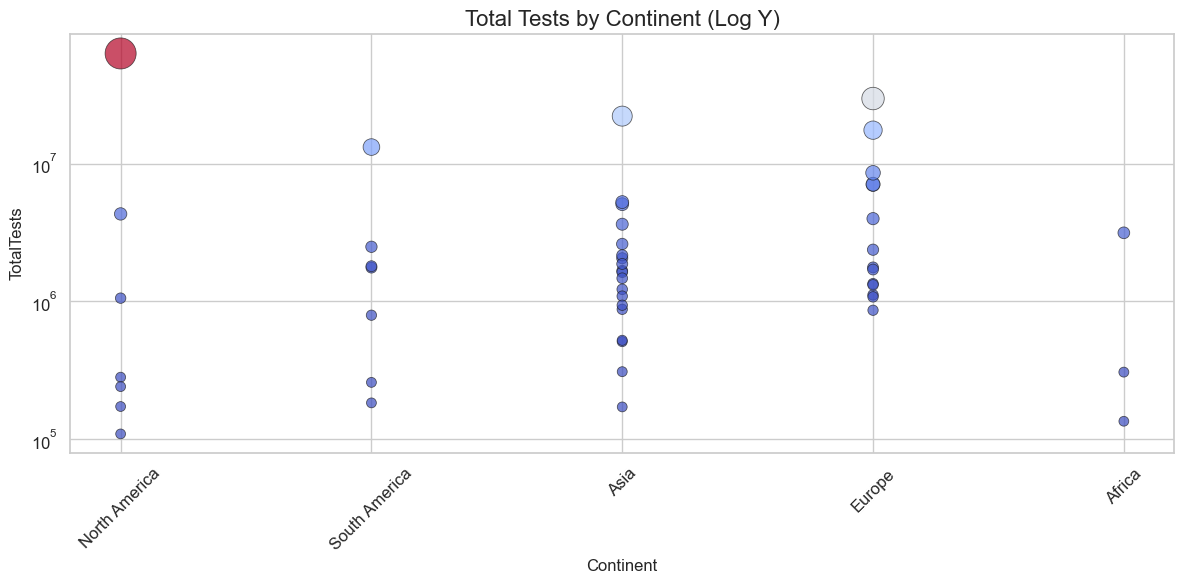

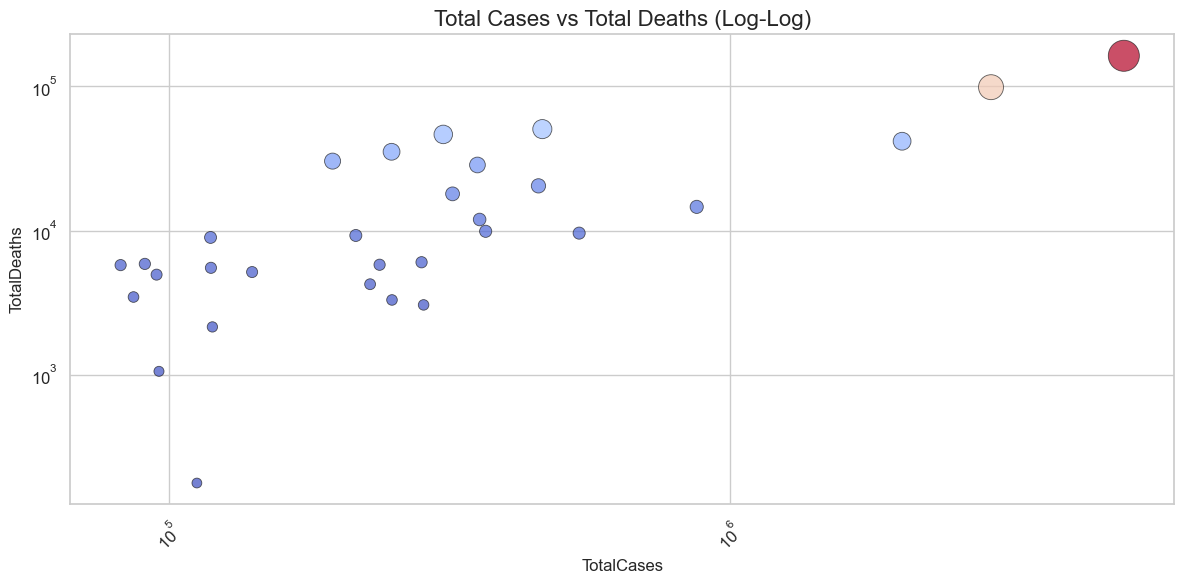

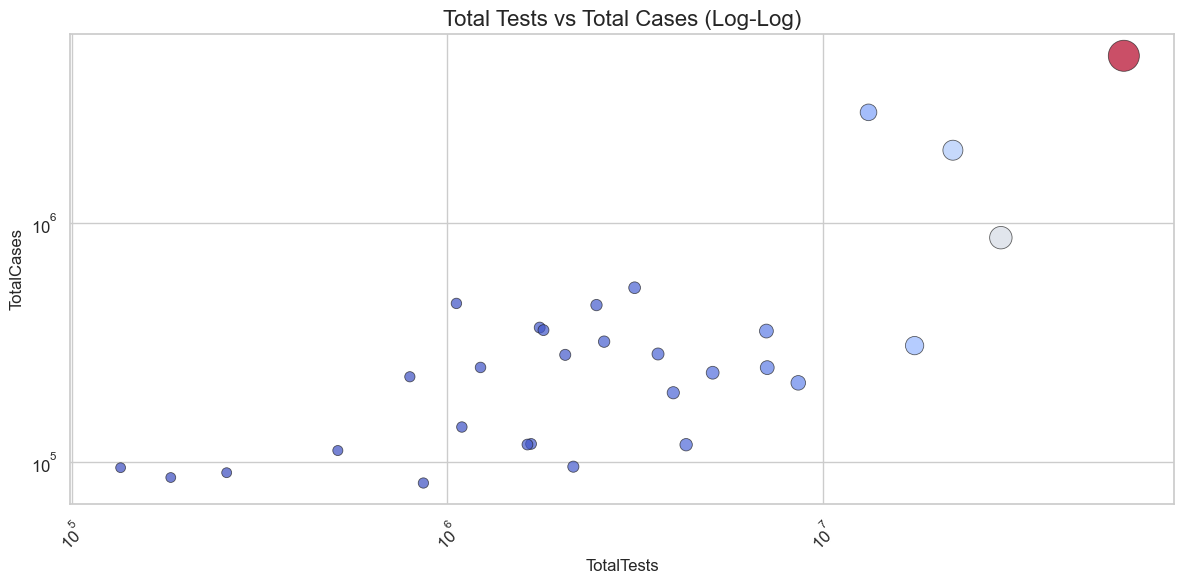

In [41]:
# --- 7. Scatter Plots ---
scatter_plot(dataset1, 'Continent', 'TotalCases', 'TotalCases', 'TotalCases', "Total Cases by Continent")
scatter_plot(dataset1.head(50), 'Continent', 'TotalTests', 'TotalTests', 'TotalTests', "Total Tests by Continent (Log Y)", log_scale_y=True)
scatter_plot(dataset1.head(30), 'TotalCases', 'TotalDeaths', 'TotalDeaths', 'TotalDeaths', "Total Cases vs Total Deaths (Log-Log)", log_scale_x=True, log_scale_y=True)
scatter_plot(dataset1.head(30), 'TotalTests', 'TotalCases', 'TotalTests', 'TotalTests', "Total Tests vs Total Cases (Log-Log)", log_scale_x=True, log_scale_y=True)


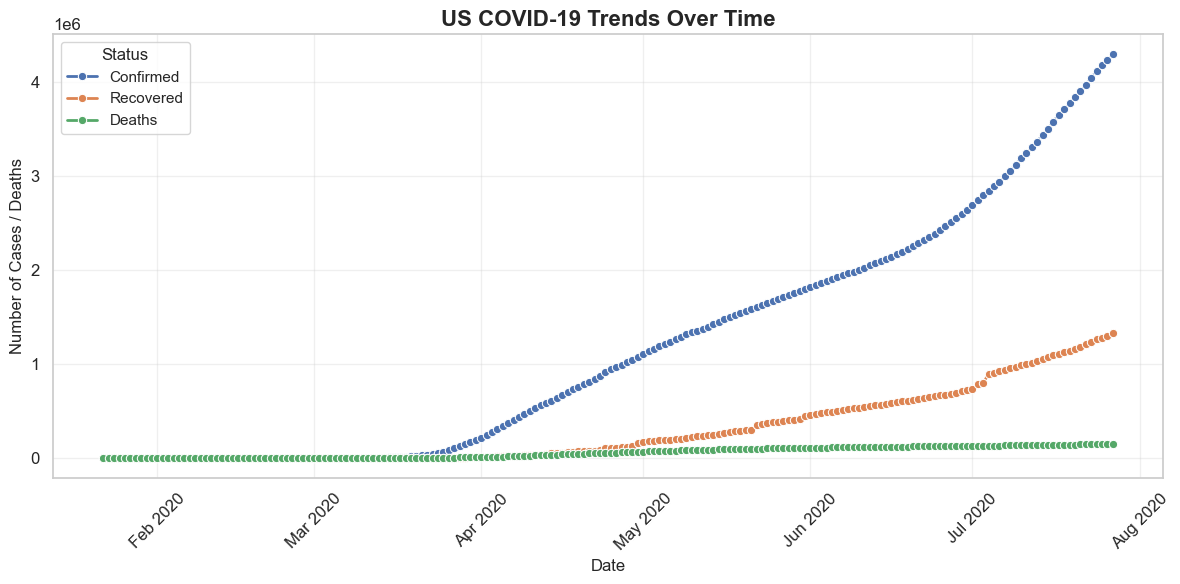

In [42]:
# --- 8. US Trends ---
import matplotlib.dates as mdates

# Always make a safe copy to avoid SettingWithCopyWarning
df_US = dataset2[dataset2["Country/Region"] == "US"].copy()

# Convert Date to datetime safely
df_US["Date"] = pd.to_datetime(df_US["Date"], errors="coerce")

# Drop rows where Date is missing
df_US = df_US.dropna(subset=["Date"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_US, x="Date", y="Confirmed", label="Confirmed", marker="o", linewidth=2)
sns.lineplot(data=df_US, x="Date", y="Recovered", label="Recovered", marker="o", linewidth=2)
sns.lineplot(data=df_US, x="Date", y="Deaths", label="Deaths", marker="o", linewidth=2)

# Beautify chart
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # show monthly ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # format: Jan 2020
plt.xticks(rotation=45)
plt.title("US COVID-19 Trends Over Time", fontsize=16, fontweight="bold")
plt.ylabel("Number of Cases / Deaths")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.legend(title="Status", loc="upper left")
plt.tight_layout()
plt.show()


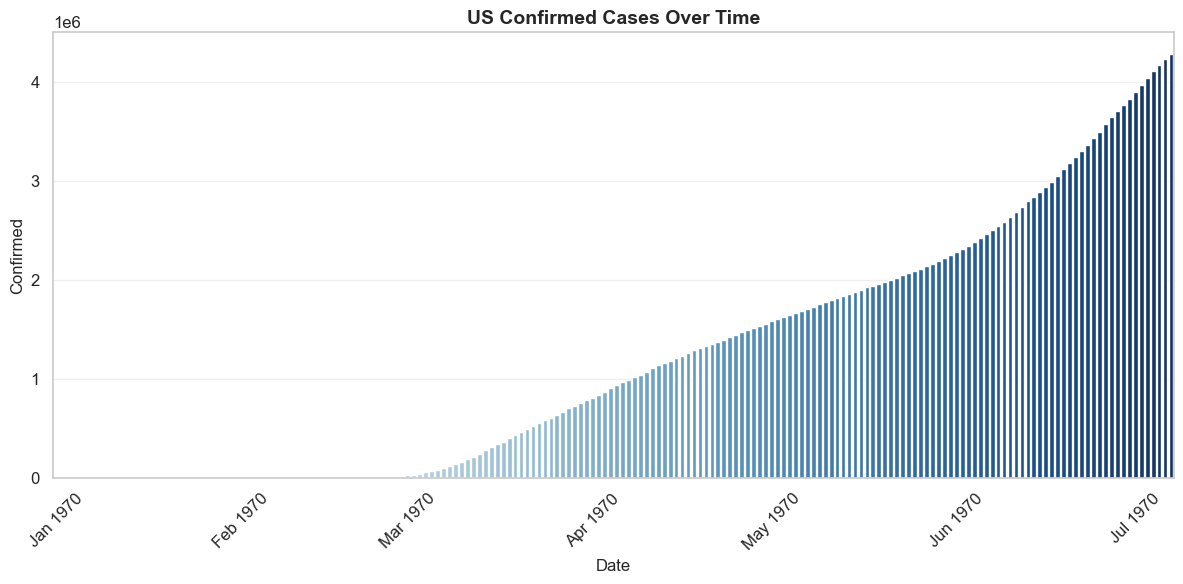

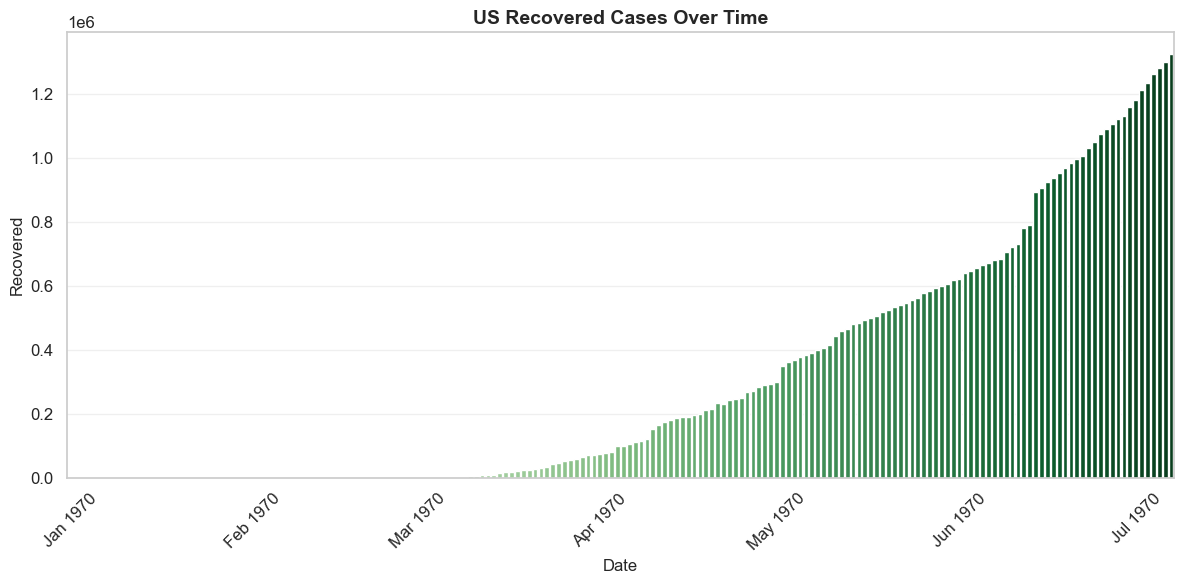

In [43]:
def bar_plot(data, x, y, title, palette='viridis', orientation='v'):
    """
    A smart Seaborn bar plot that automatically detects date columns
    and formats them nicely for time series visualization.
    """
    plt.figure(figsize=(12, 6))

    # Convert to datetime if x-axis looks like dates
    if pd.api.types.is_datetime64_any_dtype(data[x]) == False:
        try:
            data[x] = pd.to_datetime(data[x], errors='coerce')
        except Exception:
            pass

    # Drop rows where x or y are missing
    data = data.dropna(subset=[x, y])

    # Plot (orientation-aware)
    if orientation == 'h':
        sns.barplot(data=data, x=y, y=x, hue=y, palette=palette, legend=False)
    else:
        sns.barplot(data=data, x=x, y=y, hue=x, palette=palette, legend=False)

    # Format date axis if applicable
    ax = plt.gca()
    if pd.api.types.is_datetime64_any_dtype(data[x]):
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel(y)
    plt.xlabel(x)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
# --- US Bar Charts ---
bar_plot(df_US, 'Date', 'Confirmed', "US Confirmed Cases Over Time", palette='Blues')
bar_plot(df_US, 'Date', 'Recovered', "US Recovered Cases Over Time", palette='Greens')


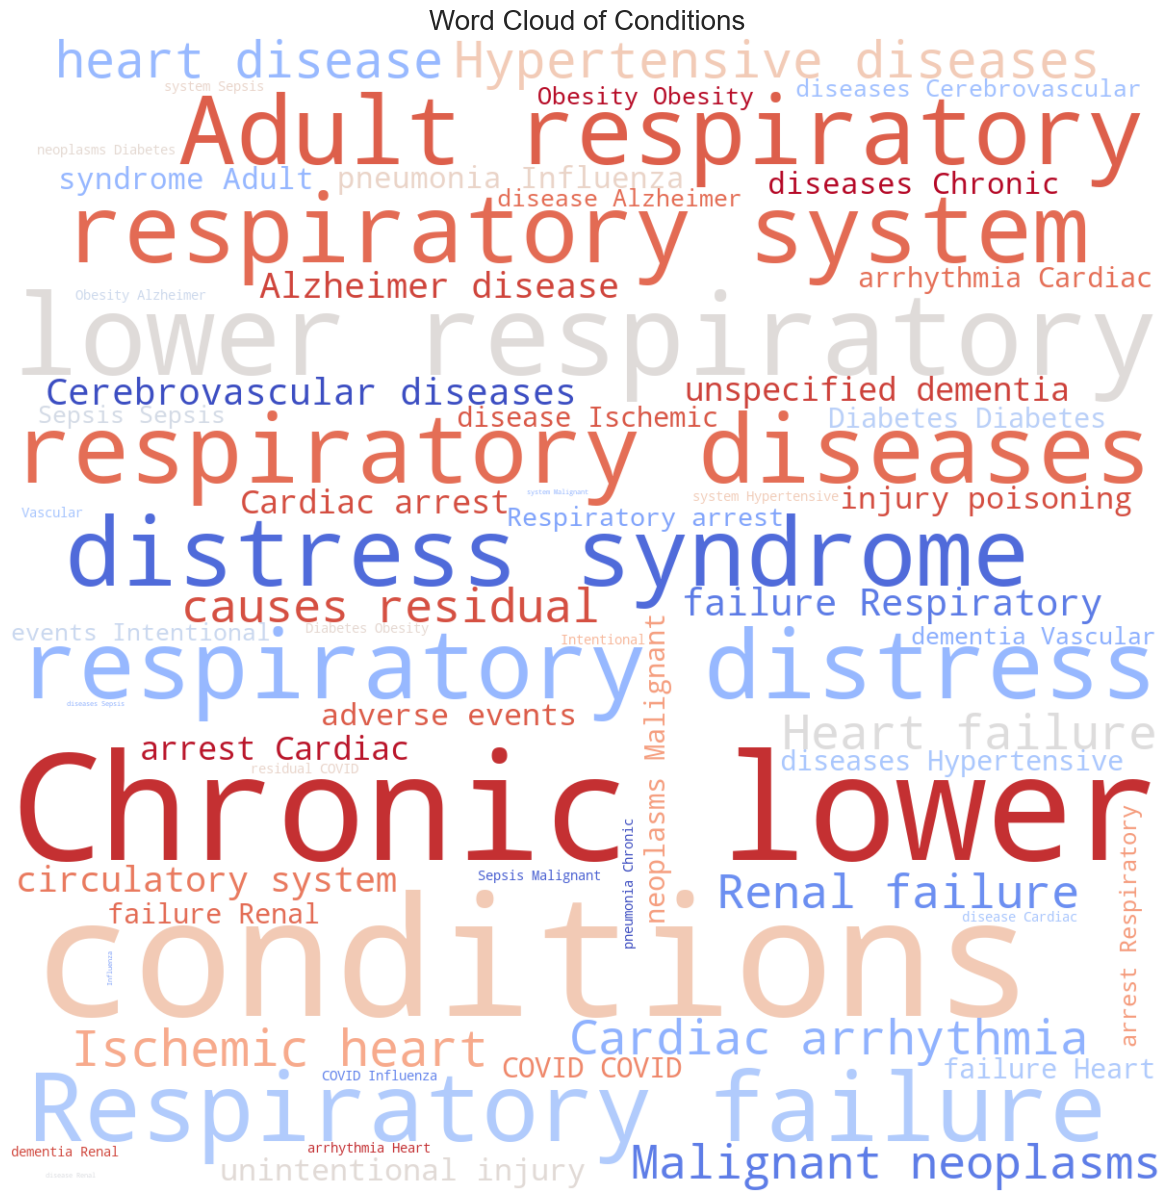

In [44]:
# --- 9. Word Clouds ---
text_cond = ' '.join(dataset3['Condition'].dropna().tolist())
generate_wordcloud(text_cond, "Word Cloud of Conditions")




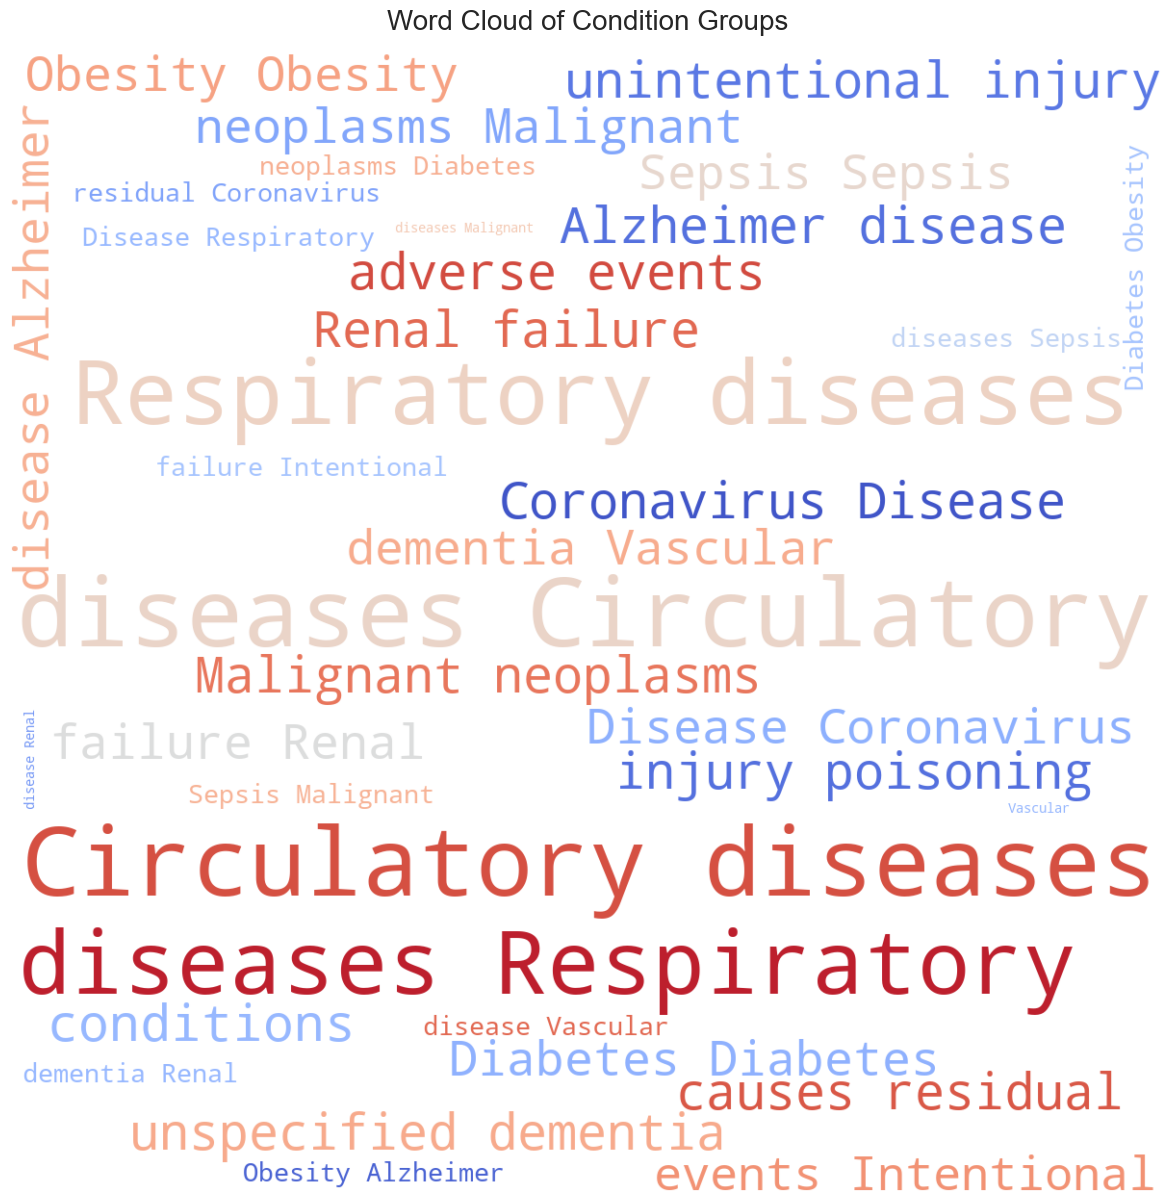

In [45]:
text_group = ' '.join(dataset3['Condition Group'].dropna().tolist())
generate_wordcloud(text_group, "Word Cloud of Condition Groups")

In [46]:
# --- END ---

print("📊 Visualization Complete | Developed by Vikas Yadav")


📊 Visualization Complete | Developed by Vikas Yadav


Thank You!
Complete Project on Github https://github.com/Vikas-Yadav-6696/COVID-19-PYTHON-DATA-ANALYSIS